1. 데이터에 한 가지 이상의 **augmentation 방법을 적용**하여 학습해 주세요.
(어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는** U-Net Generator를 사용**해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 **스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화**해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 **중간 손실 값에 대한 로그**를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

# 1. 데이터셋 전처리

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy
import tensorflow

print(numpy.__version__)
print(tensorflow.__version__)

1.21.5
2.8.0


In [4]:
import os

os.environ['HOME'] = '/content/drive/MyDrive'

data_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/train/'
val_path = os.getenv('HOME') + '/aiffel/conditional_generation/data/cityscapes/val/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


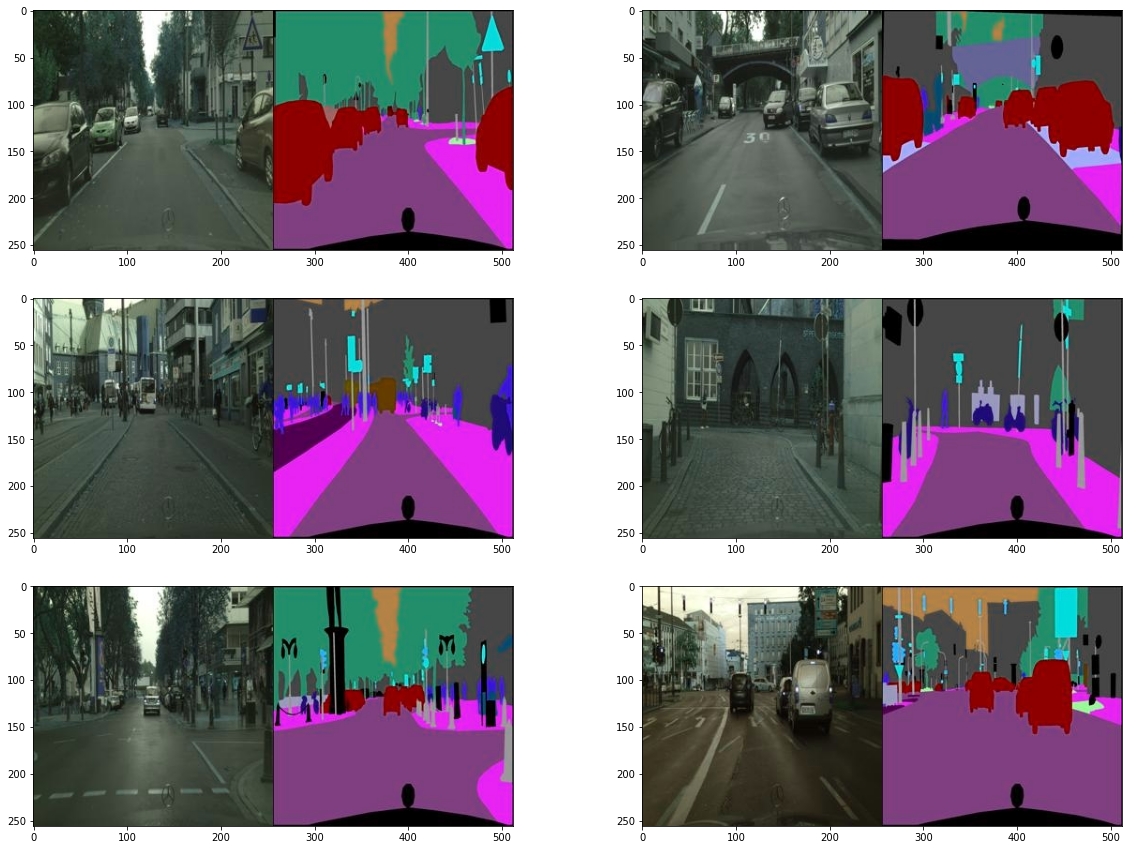

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#하나의 이미지에 단순화된 도로 이미지와 실제 도로 이미지가 함께 포함되어 있음을 확인할 수 있습니다.
plt.figure(figsize=(20,15))
for i in range(1, 7):
  f = data_path + os.listdir(data_path)[np.random.randint(800)]
  img = cv2.imread(f,cv2.IMREAD_COLOR)
  plt.subplot(3,2,i)
  plt.imshow(img)

In [6]:
# 이미지를 하나 열어 아래와 같이 크기를 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


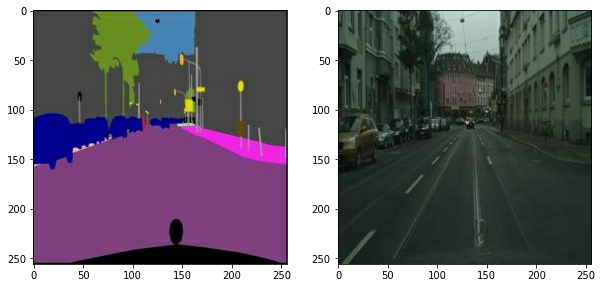

In [7]:
# (256, 512, 3)으로 확인되었습니다. 이미지가 붙어있음으로 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용
import tensorflow as tf

def normalize(x):
  x = tf.cast(x,tf.float32)
  return (x/127.5)-1

def denormalize(x):
  x = (x+1)*127.5
  x = x.numpy()
  return x.astype(np.uint8)

def load_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img,3)

  w = tf.shape(img)[1]//2
  sketch = img[:,w:,:]
  sketch = tf.cast(sketch, tf.float32)
  colored = img[:,:w,:]
  colored = tf.cast(colored, tf.float32)
  return normalize(sketch),normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch , colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [8]:
#앞서 살펴봤듯이 학습에 사용할 수 있는 데이터의 수는 약 1000개뿐입니다. 
#학습에 사용하는 데이터의 다양성을 높이기 위해 아래 코드와 같이 여러 augmentation 방법을 적용
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("done!")

done!


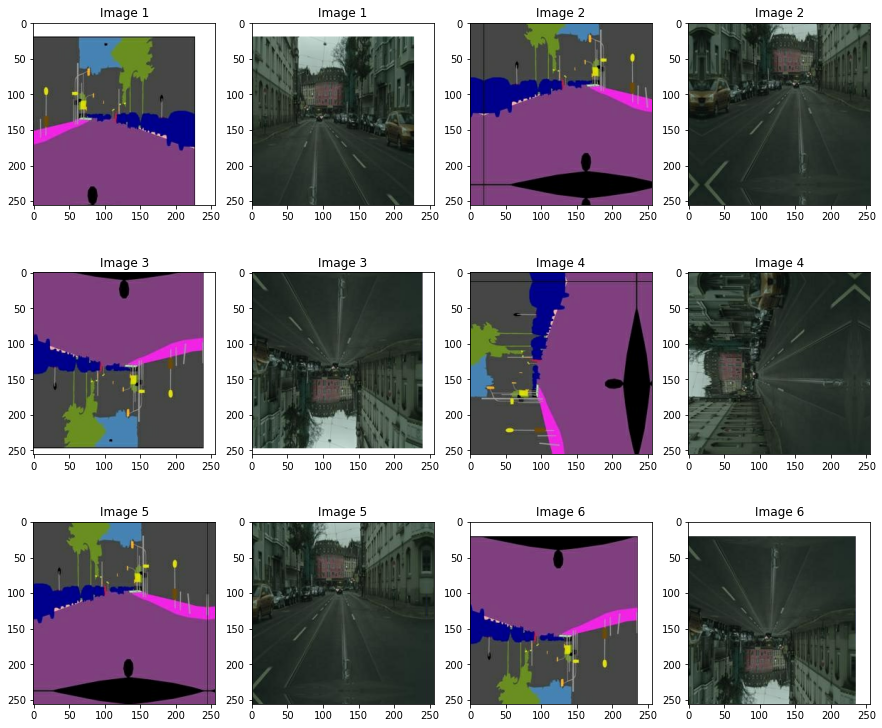

In [9]:
# augmentation 적용한 것을 시각화
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1
#사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대가능

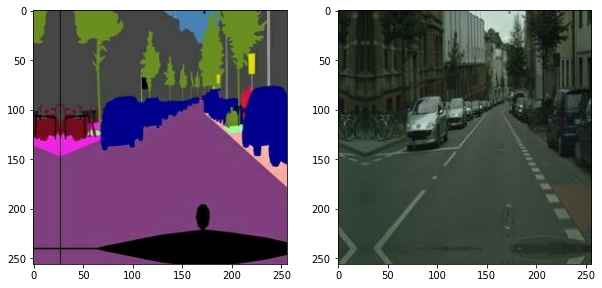

In [10]:
#위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. U-Net generator, discriminator 모델 구현

## Generator 구현하기
Generator의 Encoder 부분을 구현
 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었습니다.
 * Encoder

__init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있습니다.
이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정

Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러 번 가져다 사용하면 아래와 같이 쉽게 Encoder를 구성

* Decoder

처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인

* U-Net generator

In [11]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("done!")

done!


In [12]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("done!")

done!


In [13]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

* Discriminator 구성

In [14]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


__init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했습니다. 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능합니다.

Discriminator를 표현한 그림에서 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 언급했었습니다. 1씩 감소시키기 위한 방법이 위 질문의 답이며, 이에 대해 자세히 설명해 보겠습니다.

In [15]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_15 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [16]:
# 만든 DiscBlock을 쌓아서 Discriminator완성
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


__init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었습니다.
첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했습니다.

In [17]:
Discriminator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

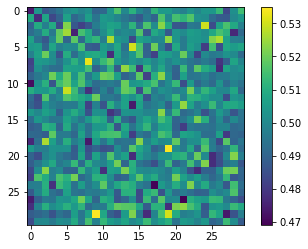

In [18]:
# 시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 3. 학습하기

In [19]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


Generator 및 Discriminator의 손실 계산을 각각 정의했습니다.

* Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있습니다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산합니다.

* Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교합니다.

In [20]:
# 사용할 optimizer는 논문과 동일하게 아래와 같이 설정
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [21]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [22]:
EPOCHS = 150

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:1.2387                     
L1_loss:0.1967                     
Discriminator_loss:1.1096

EPOCH[1] - STEP[100]                     
Generator_loss:0.9299                     
L1_loss:0.1648                     
Discriminator_loss:1.1953

EPOCH[1] - STEP[150]                     
Generator_loss:1.0720                     
L1_loss:0.1514                     
Discriminator_loss:0.9629

EPOCH[1] - STEP[200]                     
Generator_loss:2.0584                     
L1_loss:0.1498                     
Discriminator_loss:0.9218

EPOCH[1] - STEP[250]                     
Generator_loss:2.1234                     
L1_loss:0.1974                     
Discriminator_loss:0.4382

EPOCH[2] - STEP[50]                     
Generator_loss:1.4890                     
L1_loss:0.2156                     
Discriminator_loss:0.8969

EPOCH[2] - STEP[100]                     
Generator_loss:1.8099                     
L1_loss:0.1959               

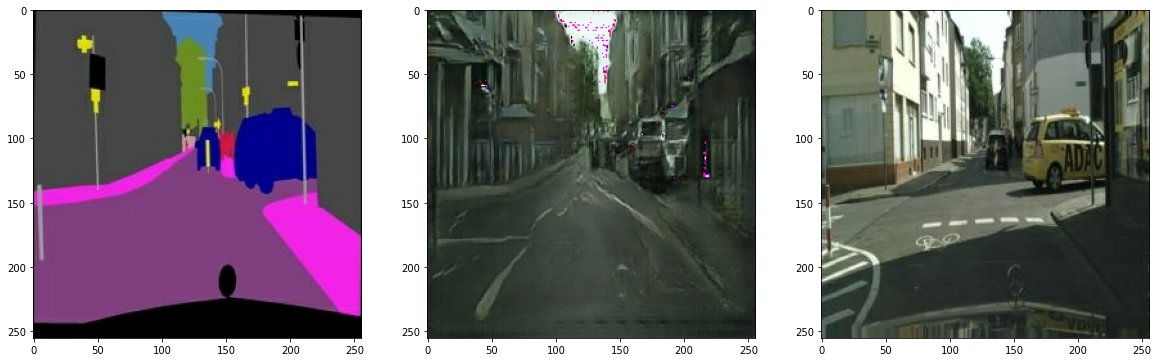

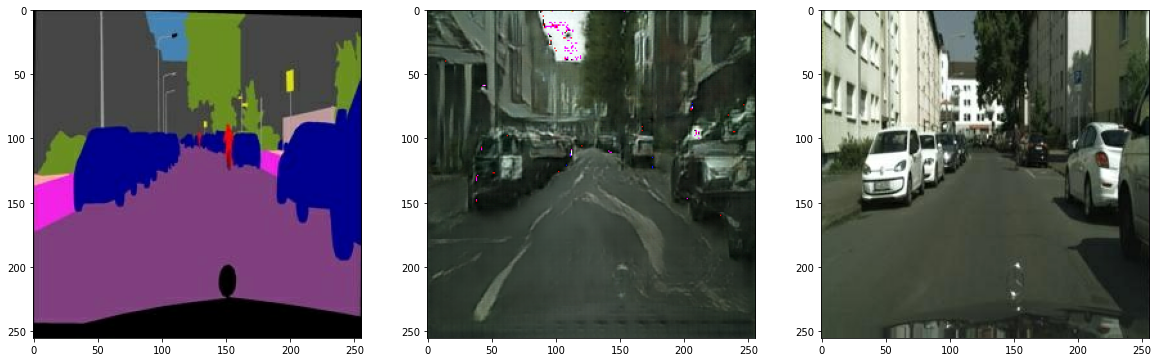

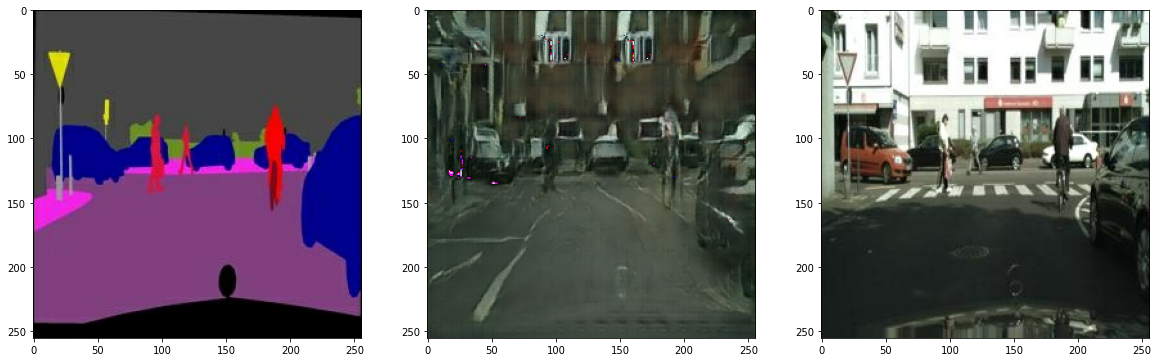

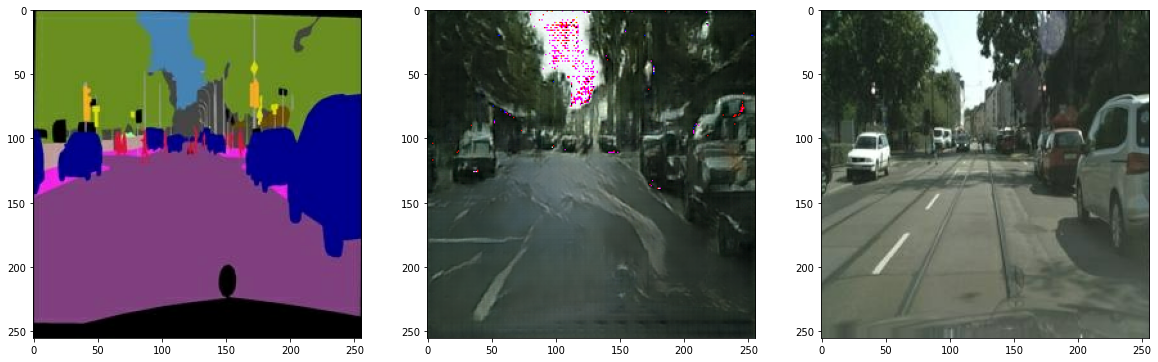

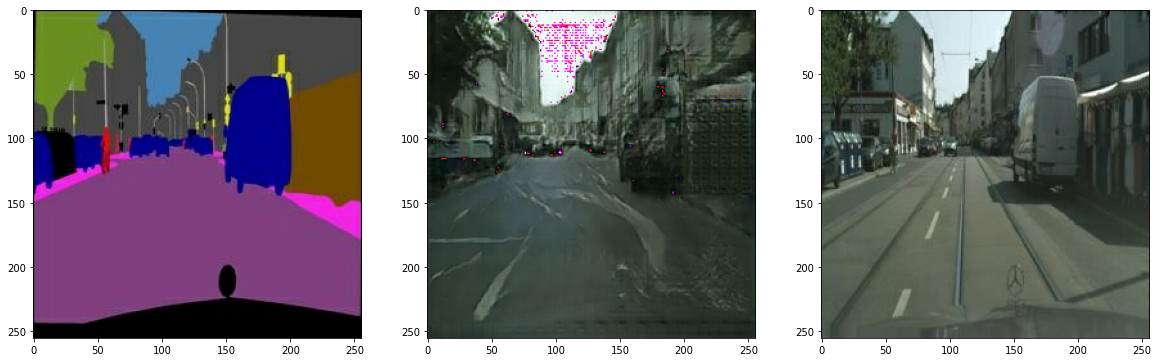

In [23]:
for i in range(5) : 
  test_ind = i

  f = val_path + os.listdir(val_path)[test_ind]
  sketch, colored = load_img(f)

  pred = generator(tf.expand_dims(sketch, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(20,10))
  plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
  plt.subplot(1,3,2); plt.imshow(pred[0])
  plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 1. pix2pix 모델 학습을 위해 필요한 데이터셋을 적절히 구축하였다.

데이터 분석 과정 및 한 가지 이상의 augmentation을 포함한 데이터셋 구축 과정이 체계적으로 제시되었다.

# 2. pix2pix 모델을 구현하여 성공적으로 학습 과정을 진행하였다.

U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행됨을 확인하였다.

# 3. 학습 과정 및 테스트에 대한 시각화 결과를 제출하였다.

10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질을 확인하였다.

# 회고
* Gan은 저번 익스에서 했을때 처럼 어렵고 에폭을 조금만 늘려도 훈련시키는거에 오래 걸려서 너무 힘들었다. 논문을 보고 파라미터값들을 다양하게 수정하고 싶었지만 마음만 먹기로했다.